# Personalized Marketing Campaign for Starbucks

(in association with Udacity)

## I. Understanding the Business

**[Starbucks Corporation](https://en.wikipedia.org/wiki/Starbucks)** is an American **coffee company and coffeehouse chain**. Starbucks locations serve hot and cold drinks, whole-bean coffee, microground instant coffee known as VIA, espresso, caffe latte, full- and loose-leaf teas including Teavana tea products, Evolution Fresh juices, Frappuccino beverages, La Boulange pastries, and snacks including items such as chips and crackers; some offerings (including their annual fall launch of the Pumpkin Spice Latte) are seasonal or specific to the locality of the store. Many stores sell pre-packaged food items, hot and cold sandwiches, and drinkware including mugs and tumblers; select "Starbucks Evenings" locations offer beer, wine, and appetizers. Starbucks-brand coffee, ice cream, and bottled cold coffee drinks are also sold at grocery stores.

### - Introduction 

Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. Also, not all users receive the same offer.

### - Goal

- Given data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products. It contains simulated data that mimics customer behavior on the Starbucks rewards mobile app.
- The **goal** is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type.
- So the guiding questions are - 
    1. Do people react to different promotions differently? 
        - If yes, how do people react to different promotions? 
    2. What are the factors affecting these reactions?

## II. Understanding the Data

The data is contained in three files:

* `portfolio.json` - containing offer ids and meta data about each offer (duration, type, etc.)
* `profile.json` - demographic data for each customer
* `transcript.json` - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**Dataset 1: `portfolio.json`**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**Dataset 2: `profile.json`**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**Dataset 3: `transcript.json`**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record


Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. It is obeserved that in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, one can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

The given transactional data shows user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Note as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

## III. Preparing the Data

In [1]:
# import necessary libraries

import pandas as pd
import numpy as np
import math
import json
import ast
import datetime
from time import time
from itertools import chain

% matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn import cluster
from sklearn.cluster import KMeans

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import fbeta_score
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

In [2]:
# read in the json files

portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

### Exploring the data:

In [3]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [4]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [5]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [6]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [7]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [8]:
# rename the columns so that it would be easy later on while merging the dataframes

portfolio.rename(columns={"id":"offer_id"}, inplace=True)
profile.rename(columns={"id":"customer_id"}, inplace=True)
transcript.rename(columns={"person":"customer_id"}, inplace=True)

It is seen that, for the the column `value`, there are multiple spellings for the same key -> 'offer id' and 'offer_id'.

In [9]:
# so to remove the above discrepancy, below logic has been used to 
# rename the keys in each dictionary of the column `value`

for i in transcript['value']:
    try:
        i['offer_id'] = i.pop('offer id')
    except:
        pass

In [10]:
# now this dictionary is to be split into three columns, 
# amount, reward and offer_id
# creating a new df

dict_df = pd.DataFrame([ast.literal_eval(json.dumps(i)) for i in transcript.value.values])

In [11]:
dict_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   offer_id  167581 non-null  object 
 1   amount    138953 non-null  float64
 2   reward    33579 non-null   float64
dtypes: float64(2), object(1)
memory usage: 7.0+ MB


In [12]:
# concatenating the earlier created df to the original dataframe

transcript = pd.concat([transcript, dict_df], 1)
transcript.head()

,customer_id,event,value,time,offer_id,amount,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer_id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer_id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN


In [13]:
# drop the original column of dictionaries as it is no longer required

del transcript['value']

In [14]:
print("Number of Unique Customer Profiles:", profile.customer_id.nunique())

# finding the intersection
print("Number of Unique Customer Profiles in `transcript` df:",
      len(set(transcript.customer_id).intersection(set(profile.customer_id))))

Number of Unique Customer Profiles: 17000
Number of Unique Customer Profiles in `transcript` df: 17000


#### The above intersection shows that **all the customer profiles are present** in the `transactions` dataframe.

In [15]:
print(profile['income'].mean())
print(profile['income'].median())

65404.9915682968
64000.0


In [16]:
# fill the unknown or missing values in gender column as NA -> not available
profile['gender'].fillna('NA', inplace=True)

# in this data, mean is higher than median, so to balance out, 
# I will fill the NaNs with median instead of mean

# fill the unknown or missing values in income column with the median
profile['income'].fillna((profile['income'].median()), inplace=True)

In [17]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            17000 non-null  object 
 1   age               17000 non-null  int64  
 2   customer_id       17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            17000 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [18]:
# Converting became_member_on to an actual date number and also creating more
# columns based on the year, month, day for further analysis

profile['member_year'] = profile.became_member_on.apply(lambda x: int(str(x)[:4]))
profile['member_month'] = profile.became_member_on.apply(lambda x: int(str(x)[4:6]))
profile['member_day'] = profile.became_member_on.apply(lambda x: int(str(x)[6:]))
profile['member_date'] = profile.became_member_on.apply(lambda x: datetime.datetime.strptime(str(x), '%Y%m%d'))
profile.drop('became_member_on', axis = 1, inplace = True)

In [19]:
# merge the transcript and profile dataframes on customer_id column
transcript = transcript.merge(profile, on=['customer_id'])

In [20]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306534 entries, 0 to 306533
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   customer_id   306534 non-null  object        
 1   event         306534 non-null  object        
 2   time          306534 non-null  int64         
 3   offer_id      167581 non-null  object        
 4   amount        138953 non-null  float64       
 5   reward        33579 non-null   float64       
 6   gender        306534 non-null  object        
 7   age           306534 non-null  int64         
 8   income        306534 non-null  float64       
 9   member_year   306534 non-null  int64         
 10  member_month  306534 non-null  int64         
 11  member_day    306534 non-null  int64         
 12  member_date   306534 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(3), int64(5), object(4)
memory usage: 32.7+ MB


In [21]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   offer_id    10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [22]:
#extract all channels names 
channels_set = set()
for i in portfolio.channels:
    channels_set.update(set(i))
# split the channel into different attribute
for i in channels_set:
    portfolio[i] = portfolio.channels.apply(lambda x: i in x).map({True:1, False: 0})

# Now drop the 'channels' column 
portfolio.drop('channels', axis=1, inplace=True)

In [23]:
portfolio.email.fillna(0, inplace=True)
portfolio.social.fillna(0, inplace=True)
portfolio.web.fillna(0, inplace=True)
portfolio.mobile.fillna(0, inplace=True)

In [24]:
# use left join to merge the transcript and portfolio dataframes on customer_id column
# left join is used because I want to preserve all the offer_ids in the transcript column
transcript = transcript.merge(portfolio, on=['offer_id'], how='left')

In [25]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306534 entries, 0 to 306533
Data columns (total 21 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   customer_id   306534 non-null  object        
 1   event         306534 non-null  object        
 2   time          306534 non-null  int64         
 3   offer_id      167581 non-null  object        
 4   amount        138953 non-null  float64       
 5   reward_x      33579 non-null   float64       
 6   gender        306534 non-null  object        
 7   age           306534 non-null  int64         
 8   income        306534 non-null  float64       
 9   member_year   306534 non-null  int64         
 10  member_month  306534 non-null  int64         
 11  member_day    306534 non-null  int64         
 12  member_date   306534 non-null  datetime64[ns]
 13  reward_y      167581 non-null  float64       
 14  difficulty    167581 non-null  float64       
 15  duration      167

In [26]:
transcript

,customer_id,event,time,offer_id,amount,reward_x,gender,age,income,member_year,...,member_day,member_date,reward_y,difficulty,duration,offer_type,email,mobile,social,web
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,F,75,100000.0,2017,...,9,2017-05-09,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0
1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,F,75,100000.0,2017,...,9,2017-05-09,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0
2,78afa995795e4d85b5d9ceeca43f5fef,transaction,132,NaN,19.89,NaN,F,75,100000.0,2017,...,9,2017-05-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,5.0,F,75,100000.0,2017,...,9,2017-05-09,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0
4,78afa995795e4d85b5d9ceeca43f5fef,transaction,144,NaN,17.78,NaN,F,75,100000.0,2017,...,9,2017-05-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306529,912b9f623b9e4b4eb99b6dc919f09a93,offer received,576,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NA,118,64000.0,2017,...,26,2017-09-26,10.0,10.0,5.0,bogo,1.0,1.0,1.0,1.0
306530,912b9f623b9e4b4eb99b6dc919f09a93,offer viewed,594,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NA,118,64000.0,2017,...,26,2017-09-26,10.0,10.0,5.0,bogo,1.0,1.0,1.0,1.0
306531,3045af4e98794a04a5542d3eac939b1f,offer received,576,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,F,58,78000.0,2016,...,20,2016-10-20,10.0,10.0,5.0,bogo,1.0,1.0,1.0,1.0
306532,3045af4e98794a04a5542d3eac939b1f,offer viewed,576,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,F,58,78000.0,2016,...,20,2016-10-20,10.0,10.0,5.0,bogo,1.0,1.0,1.0,1.0


In [27]:
def id_mapper(col_name):
    """
    INPUT: 
    col_name (str): name of the column whose values are to be changed
    
    OUTPUT:
    id_encoded (list): list of the mapped integers for each value
    
    Description:
    This function will map integers to such '912b9f623b9e4b4eb99b6dc919f09a93' long values. 
    """
    coded_dict = dict()
    cter = 1
    col_name=str(col_name)
    id_encoded = []
    
    for val in transcript[col_name]:
        try: 
            if isinstance(val, str):
                if val not in coded_dict:
                    coded_dict[val] = cter
                    cter+=1

                id_encoded.append(coded_dict[val])
            else:
                coded_dict[val] = np.nan
                id_encoded.append(coded_dict[val])
        except:
            pass
    del transcript[col_name]
    return id_encoded

# using label encoding for offer_id (10 different IDs)
le1 = preprocessing.LabelEncoder()
le1.fit(portfolio.offer_id)

# using label encoding for offer_type (3 different types, bogo-discount-informational)
le2 = preprocessing.LabelEncoder()
le2.fit(portfolio.offer_type)

# using label encoding for gender (4 different types, male-female-other-notavailable)
le3 = preprocessing.LabelEncoder()
le3.fit(profile.gender)

LabelEncoder()

In [28]:
transcript['customer_id'] = id_mapper(col_name='customer_id')

In [29]:
transcript['offer_id'] = le1.fit_transform(transcript['offer_id'].astype(str))

In [30]:
transcript['offer_type'] = le2.fit_transform(transcript['offer_type'].astype(str))

In [31]:
transcript['gender'] = le3.fit_transform(transcript['gender'].astype(str))

In [32]:
# using one hot encoding for the column `event`
transcript = pd.get_dummies(transcript, columns=['event'])

In [33]:
transcript

,time,offer_id,amount,reward_x,gender,age,income,member_year,member_month,member_day,...,offer_type,email,mobile,social,web,customer_id,event_offer completed,event_offer received,event_offer viewed,event_transaction
0,0,6,NaN,NaN,0,75,100000.0,2017,5,9,...,0,1.0,1.0,0.0,1.0,1,0,1,0,0
1,6,6,NaN,NaN,0,75,100000.0,2017,5,9,...,0,1.0,1.0,0.0,1.0,1,0,0,1,0
2,132,10,19.89,NaN,0,75,100000.0,2017,5,9,...,3,NaN,NaN,NaN,NaN,1,0,0,0,1
3,132,6,NaN,5.0,0,75,100000.0,2017,5,9,...,0,1.0,1.0,0.0,1.0,1,1,0,0,0
4,144,10,17.78,NaN,0,75,100000.0,2017,5,9,...,3,NaN,NaN,NaN,NaN,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306529,576,4,NaN,NaN,2,118,64000.0,2017,9,26,...,0,1.0,1.0,1.0,1.0,16998,0,1,0,0
306530,594,4,NaN,NaN,2,118,64000.0,2017,9,26,...,0,1.0,1.0,1.0,1.0,16998,0,0,1,0
306531,576,4,NaN,NaN,0,58,78000.0,2016,10,20,...,0,1.0,1.0,1.0,1.0,16999,0,1,0,0
306532,576,4,NaN,NaN,0,58,78000.0,2016,10,20,...,0,1.0,1.0,1.0,1.0,16999,0,0,1,0


In [34]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306534 entries, 0 to 306533
Data columns (total 24 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   time                   306534 non-null  int64         
 1   offer_id               306534 non-null  int64         
 2   amount                 138953 non-null  float64       
 3   reward_x               33579 non-null   float64       
 4   gender                 306534 non-null  int64         
 5   age                    306534 non-null  int64         
 6   income                 306534 non-null  float64       
 7   member_year            306534 non-null  int64         
 8   member_month           306534 non-null  int64         
 9   member_day             306534 non-null  int64         
 10  member_date            306534 non-null  datetime64[ns]
 11  reward_y               167581 non-null  float64       
 12  difficulty             167581 non-null  floa

In [35]:
# renaming the columns to remove space
transcript.rename(columns={"event_offer completed":"event_offer_completed",
                           "event_offer received":"event_offer_received",
                          "event_offer viewed":"event_offer_viewed"}, inplace=True)

In [36]:
# fill the NaNs with the same offer id and offer type 
# transcript.offer_id.fillna(method='ffill', inplace=True)
# transcript.offer_type.fillna(method='ffill', inplace=True)

In [37]:
# transactions_df is a dataframe which consists only of transaction events
transactions_df = transcript[transcript['event_transaction']==1]

In [38]:
# after resetting the indices, drop the unnecessary columns
transactions_df.reset_index(inplace=True)
del transactions_df['index']

In [39]:
cols_to_drop = ['time', 'offer_id', 'reward_x', 'reward_y',
       'difficulty', 'duration', 'offer_type', 'web', 'social', 'email',
       'mobile', 'event_offer_completed',
       'event_offer_received', 'event_offer_viewed']

In [40]:
for col in cols_to_drop:
    del transactions_df[col]

In [41]:
transactions_df

,amount,gender,age,income,member_year,member_month,member_day,member_date,customer_id,event_transaction
0,19.89,0,75,100000.0,2017,5,9,2017-05-09,1,1
1,17.78,0,75,100000.0,2017,5,9,2017-05-09,1,1
2,19.67,0,75,100000.0,2017,5,9,2017-05-09,1,1
3,29.72,0,75,100000.0,2017,5,9,2017-05-09,1,1
4,23.93,0,75,100000.0,2017,5,9,2017-05-09,1,1
...,...,...,...,...,...,...,...,...,...,...
138948,2.65,1,58,57000.0,2017,9,5,2017-09-05,16994,1
138949,4.62,1,48,58000.0,2018,6,10,2018-06-10,16995,1
138950,2.57,2,118,64000.0,2017,12,3,2017-12-03,16997,1
138951,12.64,2,118,64000.0,2017,12,3,2017-12-03,16997,1


In [42]:
transactions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138953 entries, 0 to 138952
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   amount             138953 non-null  float64       
 1   gender             138953 non-null  int64         
 2   age                138953 non-null  int64         
 3   income             138953 non-null  float64       
 4   member_year        138953 non-null  int64         
 5   member_month       138953 non-null  int64         
 6   member_day         138953 non-null  int64         
 7   member_date        138953 non-null  datetime64[ns]
 8   customer_id        138953 non-null  int64         
 9   event_transaction  138953 non-null  uint8         
dtypes: datetime64[ns](1), float64(2), int64(6), uint8(1)
memory usage: 9.7 MB


In [43]:
# offers_df is a dataframe which consists only of offer events
offers_df = transcript[transcript['event_transaction']!=1]

In [44]:
# after resetting the indices, drop the unnecessary columns
offers_df.reset_index(inplace=True)
del offers_df['index']

In [45]:
del offers_df['amount']

In [46]:
del offers_df['reward_x']

In [47]:
del offers_df['event_transaction']

In [48]:
offers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167581 entries, 0 to 167580
Data columns (total 21 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   time                   167581 non-null  int64         
 1   offer_id               167581 non-null  int64         
 2   gender                 167581 non-null  int64         
 3   age                    167581 non-null  int64         
 4   income                 167581 non-null  float64       
 5   member_year            167581 non-null  int64         
 6   member_month           167581 non-null  int64         
 7   member_day             167581 non-null  int64         
 8   member_date            167581 non-null  datetime64[ns]
 9   reward_y               167581 non-null  float64       
 10  difficulty             167581 non-null  float64       
 11  duration               167581 non-null  float64       
 12  offer_type             167581 non-null  int6

In [49]:
offers_df.customer_id.nunique()

16994

### Identifying groups that are the most responding to various offers: 

In [50]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306534 entries, 0 to 306533
Data columns (total 24 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   time                   306534 non-null  int64         
 1   offer_id               306534 non-null  int64         
 2   amount                 138953 non-null  float64       
 3   reward_x               33579 non-null   float64       
 4   gender                 306534 non-null  int64         
 5   age                    306534 non-null  int64         
 6   income                 306534 non-null  float64       
 7   member_year            306534 non-null  int64         
 8   member_month           306534 non-null  int64         
 9   member_day             306534 non-null  int64         
 10  member_date            306534 non-null  datetime64[ns]
 11  reward_y               167581 non-null  float64       
 12  difficulty             167581 non-null  floa

In [51]:
del transcript['reward_x']

In [52]:
# Average income of Starbucks customers
transcript['income'].mean()

64299.872118590436

In [53]:
# Average age of Starbucks customers
transcript['age'].mean()

60.90936731325073

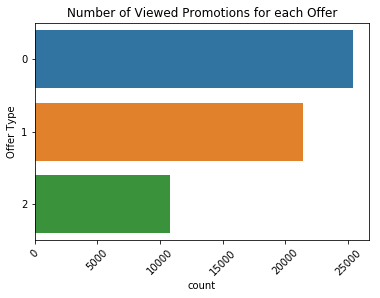

In [54]:
# Most common Offer Type Viewed
received_offer_count = transcript[transcript['event_offer_viewed']==1]

sns.countplot(y=received_offer_count['offer_type'])
plt.title('Number of Viewed Promotions for each Offer')
plt.ylabel('Offer Type')
plt.xticks(rotation = 45)
plt.show();

#### Above plot shows that the Offers of type Buy One Get One (BOGO) seem to be more attractive and they are the ones which are most viewed by the customers followed by Discount offers and then Informational 

In [55]:
le2.inverse_transform([0, 1, 2, 3])

/Users/sammitranade/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


array(['bogo', 'discount', 'informational', 'nan'], dtype=object)

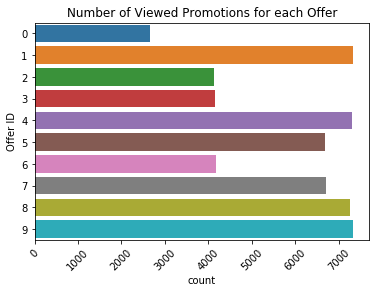

In [56]:
# Most common Offer Viewed
received_offer_count = transcript[transcript['event_offer_viewed']==1]

sns.countplot(y=received_offer_count['offer_id'])
plt.title('Number of Viewed Promotions for each Offer')
plt.ylabel('Offer ID')
plt.xticks(rotation = 45)
plt.show();

#### Above plot shows that the Offer IDs 1, 4, 8, 9 which are of types BOGO and Discount are the most viewed with dollar rewards 3, 10, 5, 2 respectively.

In [57]:
le1.inverse_transform([1, 4, 8, 9])

/Users/sammitranade/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


array(['2298d6c36e964ae4a3e7e9706d1fb8c2',
       '4d5c57ea9a6940dd891ad53e9dbe8da0',
       'f19421c1d4aa40978ebb69ca19b0e20d',
       'fafdcd668e3743c1bb461111dcafc2a4'], dtype=object)

In [58]:
portfolio

,reward,difficulty,duration,offer_type,offer_id,email,mobile,social,web
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,0,1


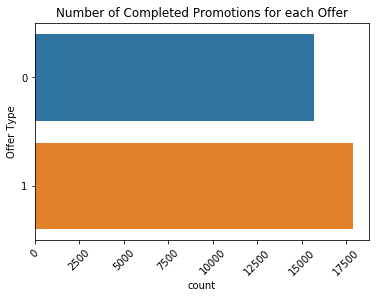

In [59]:
# Most common Offer Completed
received_offer_count = transcript[transcript['event_offer_completed']==1]

sns.countplot(y=received_offer_count['offer_type'])
plt.title('Number of Completed Promotions for each Offer')
plt.ylabel('Offer Type')
plt.xticks(rotation = 45)
plt.show();

#### Above plot shows that the Offers of type Buy One Get One (BOGO) and Discount are the only offers that are completed by the customers

In [60]:
offers_df['age_groups'] = pd.cut(offers_df.age, bins=[0, 12, 18, 21, 64, 200], 
                               labels=['child', 'teen', 'young adult', 'adult', 'elderly'])

/Users/sammitranade/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


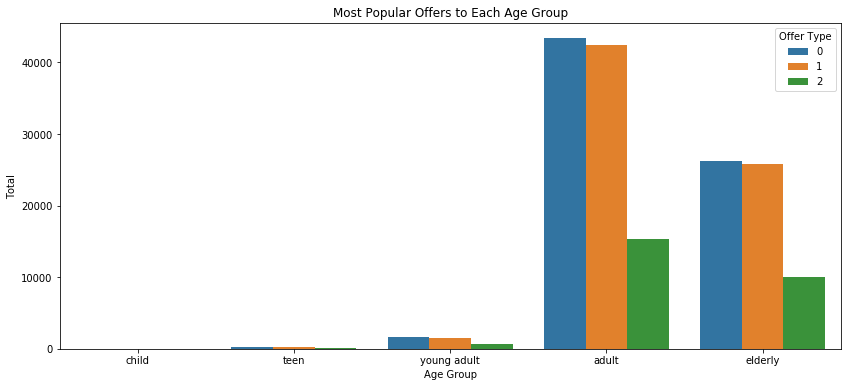

In [61]:
# Plot graph to find Most Popular Offers to Each Age Group
plt.figure(figsize=(14, 6))
sns.countplot(x="age_groups", hue="offer_type", data=offers_df)
plt.title('Most Popular Offers to Each Age Group')
plt.ylabel('Total')
plt.xlabel('Age Group')
plt.xticks(rotation = 0)
plt.legend(title='Offer Type')
plt.show();

#### BOGO being the most popular Offer Type, it is mostly used by the ADULT age group of customers followed by the ELDERLY age group.

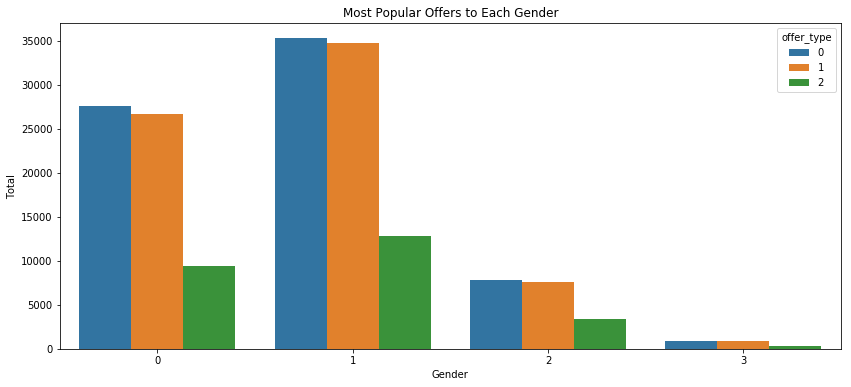

In [62]:
# Plot graph to find Most Popular Offers Gender wise
plt.figure(figsize=(14, 6))
sns.countplot(x=offers_df['gender'], hue = 'offer_type', data=offers_df)
plt.title('Most Popular Offers to Each Gender')
plt.ylabel('Total')
plt.xlabel('Gender')
plt.xticks(rotation = 0)
plt.show();

#### Same case here, BOGO being the most popular Offer Type, it is mostly used by the Males followed by the Females

In [63]:
le2.inverse_transform([0, 1, 2, 3])

/Users/sammitranade/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


array(['bogo', 'discount', 'informational', 'nan'], dtype=object)

In [64]:
le3.inverse_transform([0, 1, 2, 3])

/Users/sammitranade/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


array(['F', 'M', 'NA', 'O'], dtype=object)

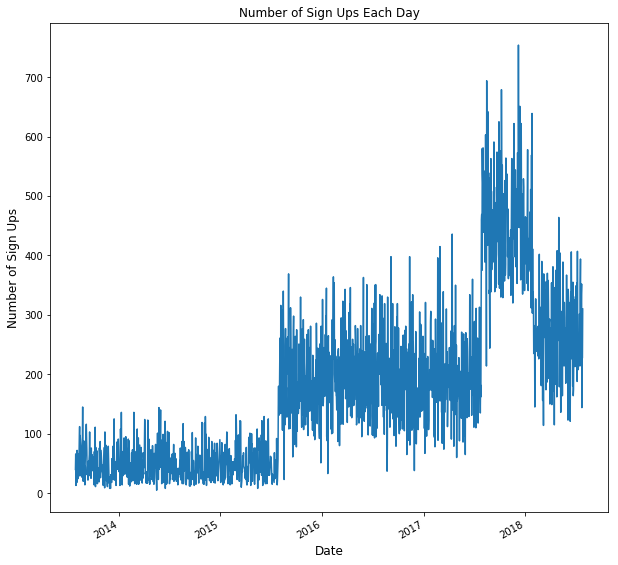

In [65]:
# Number of sign ups each day
transcript.member_date.value_counts().plot(kind = 'line', figsize = (10,10))
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Number of Sign Ups', fontsize = 12)
plt.title('Number of Sign Ups Each Day');

### It is observed that in the late 2017, the number of daily sign-ups had crossed the 500-mark, which was between 200-400, back in 2016. But decreased subsequently in 2018.

## IV. Data Modelling

### Unsupervised Learning

In [66]:
offers_df.head()

,time,offer_id,gender,age,income,member_year,member_month,member_day,member_date,reward_y,...,offer_type,email,mobile,social,web,customer_id,event_offer_completed,event_offer_received,event_offer_viewed,age_groups
0,0,6,0,75,100000.0,2017,5,9,2017-05-09,5.0,...,0,1.0,1.0,0.0,1.0,1,0,1,0,elderly
1,6,6,0,75,100000.0,2017,5,9,2017-05-09,5.0,...,0,1.0,1.0,0.0,1.0,1,0,0,1,elderly
2,132,6,0,75,100000.0,2017,5,9,2017-05-09,5.0,...,0,1.0,1.0,0.0,1.0,1,1,0,0,elderly
3,168,5,0,75,100000.0,2017,5,9,2017-05-09,0.0,...,2,1.0,1.0,1.0,0.0,1,0,1,0,elderly
4,216,5,0,75,100000.0,2017,5,9,2017-05-09,0.0,...,2,1.0,1.0,1.0,0.0,1,0,0,1,elderly


In [67]:
# dropping these columns because we dont want columns with datetime or category datatypes
del offers_df['member_date']
del offers_df['age_groups']

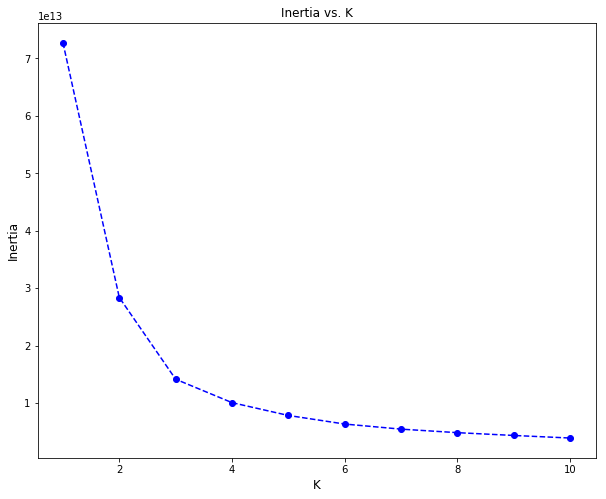

In [68]:
scores = []

# plotting the graph for Inertia (Sum of Squared Distances) v/s each K
# to find K using elbow method
for k in range(1,11):
    kmeans = KMeans(k)
    
    model = kmeans.fit(offers_df)
#     print("Inertia for k =", k, "is", model.inertia_)
    scores.append(model.inertia_)
    
plt.figure(figsize=(10,8))
plt.plot(range(1,11), scores, linestyle='--', marker='o', color='b');
plt.xlabel('K', fontsize = 12);
plt.ylabel('Inertia', fontsize = 12);
plt.title('Inertia vs. K', fontsize = 12);

In [69]:
# choosing k=2 from the above graph, as it is making an elbow at k=2
kmodel = KMeans(2, random_state=42)

clust_labels = kmodel.fit_predict(offers_df)
cent = kmodel.cluster_centers_

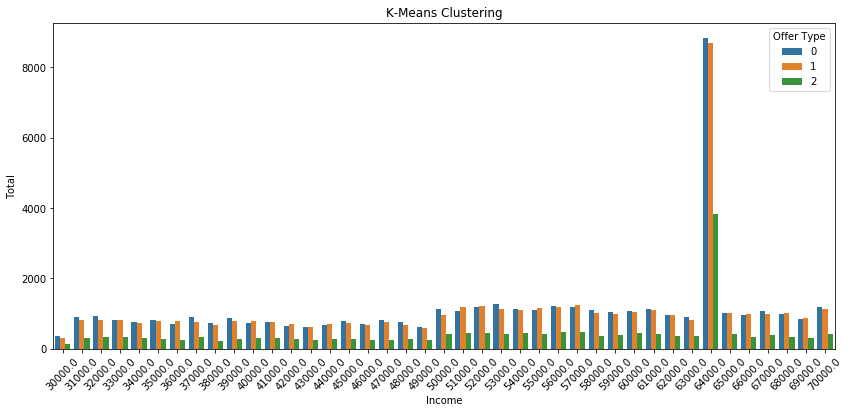

In [70]:
# Plot graph to find Most Popular Offer Type Income wise for cluster 1

plt.figure(figsize=(14, 6))
sns.countplot(x="income", hue="offer_type", data=offers_df[clust_labels==0])
plt.title('K-Means Clustering')
plt.ylabel('Total')
plt.xlabel('Income')
plt.xticks(rotation = 45)
plt.legend(title='Offer Type')
plt.show();

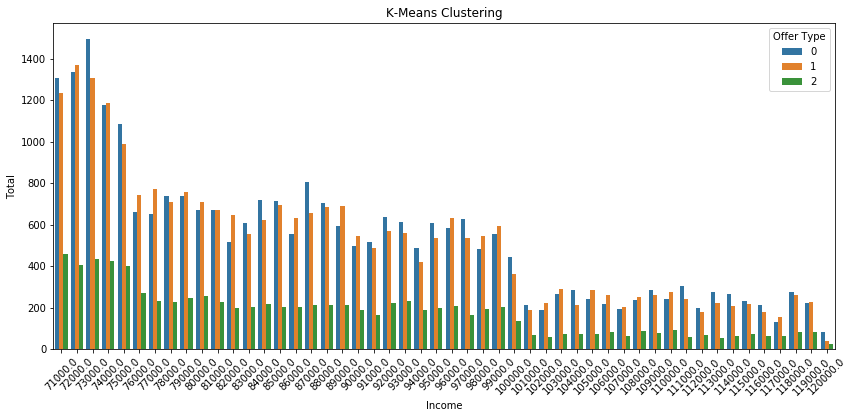

In [71]:
# Plot graph to find Most Popular Offer Type Income wise for cluster 2

plt.figure(figsize=(14, 6))
sns.countplot(x="income", hue="offer_type", data=offers_df[clust_labels==1])
plt.title('K-Means Clustering')
plt.ylabel('Total')
plt.xlabel('Income')
plt.xticks(rotation = 45)
plt.legend(title='Offer Type')
plt.show();

### INSIGHTS:
#### 1. For Cluster 1, there is a sudden rise in the histogram at income=64000 showing that more than 8000 customers have went for BOGO and discount offers.
Explanation to this is that, I have filled the NaNs with median=64000, so there is this sudden rise at income=64000.
#### 2. Compared to BOGO and Discount offer, the informational offers are not much popular.
#### 3. There are some cases where Discout Offers are used more than the BOGO offers. Like at income=51000, income=52000 in cluster 1 and income=76000, income=77000 in cluster 2.
#### 4. From the above two histograms, it can be inferred that income does not matter in customers' purchasing habits because the Total (y-axis) lies between 0 to 1500 regardless of the customers' income.

In [72]:
le3.inverse_transform([0,1,2,3])

/Users/sammitranade/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


array(['F', 'M', 'NA', 'O'], dtype=object)

In [73]:
print("Income Range for Cluster 1:", offers_df[clust_labels==0]['income'].min(), 
      "to", offers_df[clust_labels==0]['income'].max())

print("Income Range for Cluster 2:", offers_df[clust_labels==1]['income'].min(), 
      "to", offers_df[clust_labels==1]['income'].max())

Income Range for Cluster 1: 30000.0 to 70000.0
Income Range for Cluster 2: 71000.0 to 120000.0


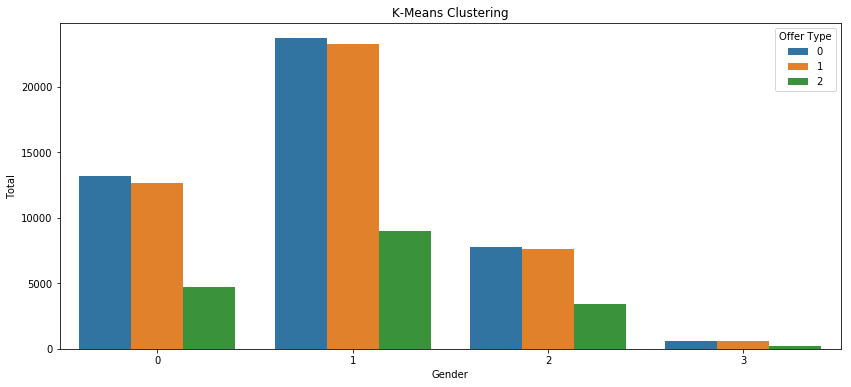

In [74]:
# Plot graph to find Most Popular Offers Type Gender wise for cluster 1

plt.figure(figsize=(14, 6))
sns.countplot(x="gender", hue="offer_type", data=offers_df[clust_labels==0])
plt.title('K-Means Clustering')
plt.ylabel('Total')
plt.xlabel('Gender')
plt.xticks(rotation = 0)
plt.legend(title='Offer Type')
plt.show();

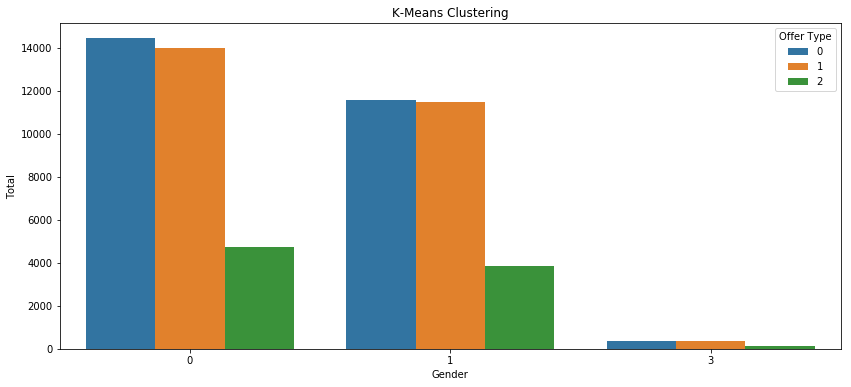

In [75]:
# Plot graph to find Most Popular Offers Type Gender wise for cluster 2

plt.figure(figsize=(14, 6))
sns.countplot(x="gender", hue="offer_type", data=offers_df[clust_labels==1])
plt.title('K-Means Clustering')
plt.ylabel('Total')
plt.xlabel('Gender')
plt.xticks(rotation = 0)
plt.legend(title='Offer Type')
plt.show();

### INSIGHTS:
#### 1. For Cluster 1, the income ranges from 30000.0 to 70000.0. So it can be inferred that Males with income range 30000.0 to 70000.0 tend to spend more than Females and Other Genders for the BOGO and Discount Offers ( This inference is excluding the unknown and missing values).
#### 2. For Cluster 2, the income ranges from 71000.0 to 120000.0. So it can be inferred that Females with income range 71000.0 to 120000.0 tend to spend more than Males and Other Genders for the BOGO and Discount Offers.
#### 3. Compared to BOGO and Discount offer, the informational offers are not much popular.

### Supervised Learning

### The target is `offer_type`. This will give us a personalized prediction for each customer to send an offer. 

In [76]:
offers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167581 entries, 0 to 167580
Data columns (total 20 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   time                   167581 non-null  int64  
 1   offer_id               167581 non-null  int64  
 2   gender                 167581 non-null  int64  
 3   age                    167581 non-null  int64  
 4   income                 167581 non-null  float64
 5   member_year            167581 non-null  int64  
 6   member_month           167581 non-null  int64  
 7   member_day             167581 non-null  int64  
 8   reward_y               167581 non-null  float64
 9   difficulty             167581 non-null  float64
 10  duration               167581 non-null  float64
 11  offer_type             167581 non-null  int64  
 12  email                  167581 non-null  float64
 13  mobile                 167581 non-null  float64
 14  social                 167581 non-nu

In [95]:
# Split the Data into Target and Features variables

target = offers_df['offer_type']
features = offers_df.drop(['offer_type', 'customer_id', 'offer_id'], axis=1)

In [96]:
# split the data into train and test sets

X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=42)

In [97]:
print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (125685, 17)
Training Labels Shape: (125685,)
Testing Features Shape: (41896, 17)
Testing Labels Shape: (41896,)


In [98]:
def train_predict(learner, X_train, y_train, X_test, y_test): 
    '''
    INPUT:
       - learner: the learning algorithm to be trained and predicted
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # Fit the learner to the training data
    start = time() # Get start time
    learner.fit(X_train, y_train)
    end = time() # Get end time
    
    # Calculate the training time
    results['train_time'] = (end - start)
        
    # Get the predictions on the test set(X_test),
    # then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    # now, since we have get predictionns on the first 300 samples
    predictions_train = learner.predict(X_train[:300]) 
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = (end - start)
            
    # Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
        
    # Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # Compute F-score on the the first 300 training samples using fbeta_score()
    # average = weighted because multiclass classification
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, beta = 0.5, average='weighted')
        
    # Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test, predictions_test, beta = 0.5, average='weighted')
       
    # Success
    print("{} trained.".format(learner.__class__.__name__))
        
    # Return the results
    return results

In [99]:
# Initialize the models
# Initializing random_state to arbitrary number 42 because the seed will be set common for all clfs
clf_A = LogisticRegression(random_state=42)
clf_B = KNeighborsClassifier()
clf_C = GaussianNB()
clf_D = RandomForestClassifier(random_state=42)

In [100]:
# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C, clf_D]:
    clf_name = clf.__class__.__name__
    print(clf_name)
    results[clf_name] = {}
    results[clf_name] = train_predict(clf, X_train, y_train, X_test, y_test)

LogisticRegression
LogisticRegression trained.
KNeighborsClassifier
KNeighborsClassifier trained.
GaussianNB
GaussianNB trained.
RandomForestClassifier
RandomForestClassifier trained.


In [101]:
for i in results.items():
    print (i[0])
    display(pd.DataFrame(i[1], index=range(1)))

LogisticRegression


,train_time,pred_time,acc_train,acc_test,f_train,f_test
0,3.830473,0.007071,1.0,1.0,1.0,1.0


KNeighborsClassifier


,train_time,pred_time,acc_train,acc_test,f_train,f_test
0,0.615193,1.941764,0.856667,0.753938,0.859477,0.760623


GaussianNB


,train_time,pred_time,acc_train,acc_test,f_train,f_test
0,0.060601,0.015381,1.0,1.0,1.0,1.0


RandomForestClassifier


,train_time,pred_time,acc_train,acc_test,f_train,f_test
0,0.341185,0.027365,1.0,1.0,1.0,1.0


#### With classifiers like RandomForest and LogisticRegression there is a chance that these models might overfit and obviously this is the case happening here. 
#### So I would go with the KNeighbors Classifier to predict the ` offer_type`. Here the training accuracy is very good ~ 85.66% whereas the testing accuracy is good ~ 75.39%

## V. Evaluating the Results - Summary

#### Suppose we have the following past data of a customer:

In [103]:
past_data = [0, 1, 45, 100000.0, 2018, 6, 22, 10.0, 10.0, 5.0, 1.0, 1.0, 1.0, 1.0, 1, 0, 0]

In [104]:
clf = KNeighborsClassifier()

In [105]:
clf.fit(features, target)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [106]:
clf.score(features, target)

0.8799028529487233

In [107]:
predictions_test = clf.predict([past_data])

In [108]:
predictions_test

array([0])

#### This tells us that this customer is most likely to respod to another BOGO offer with probability of around 89%

### Summarizing the all the above calculations it can be concluded that:

1. People react to different promotions differently.
2. Customers are attracted to BOGO and Discount offers more as compared to Informational Offers
3. Factors like **Age, Gender, Income** of the *customers* and the **Rewards** which customers receive from each *offer* are the factors which affect the customers reactions positively. 
4. Also, a predictive model is built to predict which offer a customer is most likely to interact with if we have that customer's past data.